#Applying LSTM to generate text

In this project, we would like to create a language model that is capable of generating text.

In [2]:
import random
import sys
import time
import numpy as np
from keras import layers
from tensorflow import keras
import pickle

In [3]:
path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')

text = open(path).read().lower()
print('Corpus length: ', len(text))

614400/600901 [==============================] - 0s 0us/step
Corpus length:  600893


In [12]:
text [1: 100]

'reface\n\n\nsupposing that truth is a woman--what then? is there not ground\nfor suspecting that all ph'

In [4]:
#length of extracted char sequence
max_len = 50

#we sample a new sequence every 'step' char
step = 4

#sentences holds our extracted sequence
sentences = []

#holding the targets or labels (the following chars)
next_char = []

for i in range(0, len(text)-max_len, step):
  sentences.append(text[i: i+max_len])
  next_char.append(text[i+max_len])

print('the number of sequence: ', len(sentences))

#list of unique chars in the corpus
chars = sorted(list(set(text)))
print('the number of unique chars: ', len(chars))
#dictionary mapping unique chars to their index in 'chars'
char_indices = dict((char, chars.index(char)) for char in chars)

#the chars one-hot representation into binary arrays
print('Vectorization...')
x = np.zeros((len(sentences), max_len, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
  for t, char in enumerate(sentence):
    x[i, t, char_indices[char]] = 1
  y[i, char_indices[next_char[i]]] = 1


the number of sequence:  200278
the number of unique chars:  57
Vectorization...


#Build the network

The network is a single-layer LSTM followed by a Dense classifier and 'softmax' over all possible characters.

In [5]:
model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(max_len, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

In [6]:
#compile the model
opt = keras.optimizers.RMSprop(lr=0.01)
lss = 'categorical_crossentropy'
model.compile(loss=lss, optimizer=opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
#pick a weighted random char based on probability of next_char instead of maximum probability
def sample(preds, temprature=1.0):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temprature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

#look at the below digram from François Chollet book (chapter 8)!

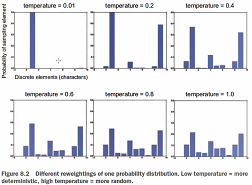

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
#train the model



checkpoint_filepath = '/content/gdrive/MyDrive/CheckPoints/LSTMGeneratingtext/'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    # monitor='loss',
    mode='auto',
    # save_best_only=True
    )



try:
  with open(checkpoint_filepath + '/Params.pickle', 'rb') as handle:
    start_epoch = pickle.load(handle)
    model.load_weights(checkpoint_filepath)
    print('starting from epoch = ', start_epoch)
except:
  print('Checkpoint not loaded')
  start_epoch = 1


t0 = time.time()
for epoch in range(start_epoch, 100):
  print('epoch', epoch)
  # fit the model
  model.fit(x, y, batch_size=128, epochs=1, callbacks=[model_checkpoint_callback])

  #updaing (dumpping) pickle 
  with open(checkpoint_filepath + '/Params.pickle', 'wb') as handle:
    pickle.dump(epoch, handle, protocol=pickle.HIGHEST_PROTOCOL)

  #select a text seed at random
  start_index = random.randint(0, len(text)-max_len-1)
  generated_text = text[start_index: start_index+max_len]
  print('----------------generating with seed: "', generated_text, '"')

  if epoch % 99 != 0:
    continue

  for temperature in [0.2, 0.5, 1.0, 1.2]:
    print('----------------------temperature----------------------: ', temperature)
    sys.stdout.write(generated_text)

    #generating 400 chars for instance
    for i in range(50):
      sampled = np.zeros((1, max_len, len(chars)))
      for t, char in enumerate(generated_text):
        sampled[0, t, char_indices[char]] = 1 

        preds = model.predict(sampled, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        generated_text += next_char
        generated_text = generated_text[1: ]
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
      
      print()

t1 = time.time()

starting from epoch =  99
epoch 99
1565/1565 [==============================] - 26s 17ms/step - loss: 2.9936
----------------generating with seed: " ch is here decisive and determines the order of
rank--to emp "
----------------------temperature----------------------:  0.2
ch is here decisive and determines the order of
rank--to emp    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


c   e       e     e       o        e          ii        
                         e          a e           t e   t tt
         ee    e      e       t  e      r e   ea           e
  e   oe        o       eat    a  e   e    e              e 
    ee      e    e              i              iae e  e    u
             o    s   i        t     t  ee  e             ae
            e    e  e           e  e     o     e          e 
   e  e     e  e i i          ee                     e    et
  e             e  e   t       e                   e o  ear 
 r       ee       i                e        o    t    ee  e 
        i          s     e       e    e         e     o   et
 e    e             te        e         t  i        t      a
          ea   i            i         i         i  e    o  i
  e  a       e                   e    e   r          e      
                                e            te    e    oo  
      t                 a                e e    t          o
 e       e                  